## Import Dependencies

In [15]:
import pandas as pd
import numpy as np
import geopandas as gpd
from fastkml import kml
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Load the NYC Building Footprints Dataset

In [ ]:
# Load the dataset
nyc_buildings_path = "/content/drive/MyDrive/EY Challenge 2025/Dataset/Building_Footprints_20250316.csv"
nyc_buildings_df = pd.read_csv(nyc_buildings_path, low_memory=False)

In [ ]:
nyc_buildings_df.head(1)

,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,NaN,3170958,1925.0,08/22/2017,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}


In [ ]:
# Display basic statistics
print("Basic statistics")
print(nyc_buildings_df.describe())

# Display basic info
print("\nBasic information")
print(nyc_buildings_df.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(nyc_buildings_df.isnull().sum())

Basic statistics
                BIN    CNSTRCT_YR      DOITT_ID    HEIGHTROOF     FEAT_CODE  \
count  1.082809e+06  1.072597e+06  1.082809e+06  1.082809e+06  1.082809e+06   
mean   3.713359e+06  1.939706e+03  5.954137e+05  2.775406e+01  2.693219e+03   
std    1.026557e+06  2.955633e+01  3.626091e+05  2.215546e+01  1.198303e+03   
min    1.000000e+06  1.652000e+03  1.000000e+00  0.000000e+00  1.000000e+03   
25%    3.129910e+06  1.920000e+03  2.882940e+05  1.853000e+01  2.100000e+03   
50%    4.068040e+06  1.930000e+03  5.767890e+05  2.614000e+01  2.100000e+03   
75%    4.483652e+06  1.955000e+03  8.671370e+05  3.116000e+01  2.100000e+03   
max    5.799523e+06  2.025000e+03  1.303208e+06  1.550000e+03  5.110000e+03   

         GROUNDELEV  SHAPE_AREA  SHAPE_LEN      BASE_BBL    MPLUTO_BBL  
count  1.082258e+06   1082809.0  1082809.0  1.082809e+06  1.082809e+06  
mean   5.512581e+01         0.0        0.0  3.564438e+09  3.564438e+09  
std    4.152793e+01         0.0        0.0  9.857466

In [ ]:
selected_cols = ['the_geom', 'HEIGHTROOF', 'GROUNDELEV']
nyc_buildings_height_df = nyc_buildings_df[selected_cols].copy()  # Ensure it's a full copy

In [ ]:
nyc_buildings_height_df.head(1)

,the_geom,HEIGHTROOF,GROUNDELEV
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,29.749853,40.0


In [ ]:
from shapely.wkt import loads

# Ensure you're working with a full copy of the DataFrame
#nyc_buildings_height_df = nyc_buildings_height_df.copy()

# Convert 'the_geom' column from WKT (Well-Known Text) to actual geometries
#nyc_buildings_height_df.loc[:, "geometry"] = nyc_buildings_height_df["the_geom"].apply(loads)
nyc_buildings_height_df["geometry"] = nyc_buildings_height_df["the_geom"].apply(loads)


# Allows extracting latitude & longitude from the building footprint centroid
# Enables spatial operations like merging with UHI data
# Supports calculations like building area, distances, and intersections

# Convert to a GeoDataFrame
nyc_buildings_gdf = gpd.GeoDataFrame(nyc_buildings_height_df, geometry="geometry", crs="EPSG:4326")

In [ ]:
nyc_buildings_gdf.head(1)

,the_geom,HEIGHTROOF,GROUNDELEV,geometry
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,29.749853,40.0,"MULTIPOLYGON (((-73.96665 40.626, -73.96685 40..."


In [ ]:
# Extract latitude and longitude from the geometry column (building centroids)
#nyc_buildings_gdf["latitude"] = nyc_buildings_gdf.geometry.centroid.y
#nyc_buildings_gdf["longitude"] = nyc_buildings_gdf.geometry.centroid.x

In [ ]:
# Reproject to a Projected CRS for NYC (EPSG:2263 - NAD83 / New York Long Island)
nyc_buildings_gdf = nyc_buildings_gdf.to_crs(epsg=2263)

# Compute centroids in the projected CRS
nyc_buildings_gdf["centroid"] = nyc_buildings_gdf.geometry.centroid

# Reproject back to EPSG:4326 for latitude & longitude
nyc_buildings_gdf = nyc_buildings_gdf.set_geometry("centroid").to_crs(epsg=4326)

# Extract latitude and longitude from centroid
nyc_buildings_gdf["latitude"] = nyc_buildings_gdf.centroid.y
nyc_buildings_gdf["longitude"] = nyc_buildings_gdf.centroid.x

<ipython-input-41-48377f655b53>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_buildings_gdf["latitude"] = nyc_buildings_gdf.centroid.y
<ipython-input-41-48377f655b53>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_buildings_gdf["longitude"] = nyc_buildings_gdf.centroid.x


In [ ]:
# Reproject to a Projected CRS for NYC (EPSG:2263 - NAD83 / New York Long Island)
nyc_buildings_gdf = nyc_buildings_gdf.to_crs(epsg=2263)

# Compute centroids in projected CRS
nyc_buildings_gdf["centroid"] = nyc_buildings_gdf.geometry.centroid

# Create a separate GeoDataFrame for centroids and reproject back to EPSG:4326
centroids_gdf = nyc_buildings_gdf.set_geometry("centroid").to_crs(epsg=4326)

# Extract latitude and longitude from the centroid
centroids_gdf["latitude"] = centroids_gdf.geometry.y
centroids_gdf["longitude"] = centroids_gdf.geometry.x

# Merge back latitude and longitude into the original dataset
nyc_buildings_gdf["latitude"] = centroids_gdf["latitude"]
nyc_buildings_gdf["longitude"] = centroids_gdf["longitude"]

In [ ]:
nyc_buildings_gdf.head(1)

,the_geom,HEIGHTROOF,GROUNDELEV,geometry,centroid,latitude,longitude
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,29.749853,40.0,"MULTIPOLYGON (((993508.772 167345.645, 993452....",POINT (993484.219 167355.101),40.626023,-73.966734


In [ ]:
# Keep only necessary columns
nyc_buildings_gdf = nyc_buildings_gdf[["latitude", "longitude", "HEIGHTROOF", "GROUNDELEV"]]

In [ ]:
nyc_buildings_gdf

,latitude,longitude,HEIGHTROOF,GROUNDELEV
0,40.626023,-73.966734,29.749853,40.0
1,40.639322,-74.167951,22.630000,39.0
2,40.556102,-74.195179,35.760000,51.0
3,40.577416,-73.961166,37.500000,6.0
4,40.755844,-73.754285,18.015113,93.0
...,...,...,...,...
1082804,40.639133,-73.949542,55.000000,29.0
1082805,40.678381,-73.958195,0.000000,93.0
1082806,40.735252,-73.959734,0.000000,11.0
1082807,40.654179,-73.954323,0.000000,NaN


## Combine the NYC Building Footprints Dataset with the UHI Index Trainind dataset

In [ ]:
min=(-73.994457, 40.758792)
max=(-73.879458, 40.859497)

In [ ]:
# Load the ground (basic) data from csv file
uhi_df = pd.read_csv("/content/drive/MyDrive/EY Challenge 2025/Dataset/Training_data_uhi_index.csv")
uhi_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [ ]:
# Display basic statistics
print("Basic statistics")
print(uhi_df.describe())

# Display basic info
print("\nBasic information")
print(uhi_df.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(uhi_df.isnull().sum())

Basic statistics
          Longitude      Latitude     UHI Index
count  11229.000000  11229.000000  11229.000000
mean     -73.933927     40.808800      1.000001
std        0.028253      0.023171      0.016238
min      -73.994457     40.758792      0.956122
25%      -73.955703     40.790905      0.988577
50%      -73.932968     40.810688      1.000237
75%      -73.909647     40.824515      1.011176
max      -73.879458     40.859497      1.046036

Basic information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11229 non-null  float64
 1   Latitude   11229 non-null  float64
 2   datetime   11229 non-null  object 
 3   UHI Index  11229 non-null  float64
dtypes: float64(3), object(1)
memory usage: 351.0+ KB
None

Number of missing values in each column
Longitude    0
Latitude     0
datetime     0
UHI Index    0
dtype: int64


In [ ]:
# Convert UHI dataset to GeoDataFrame
uhi_gdf = gpd.GeoDataFrame(
    uhi_df,
    geometry=gpd.points_from_xy(uhi_df['Longitude'], uhi_df['Latitude']),
    crs="EPSG:4326"  # Ensure it's in the correct geographic CRS
)

# Convert buildings dataset to GeoDataFrame
buildings_gdf = gpd.GeoDataFrame(
    nyc_buildings_gdf,
    geometry=gpd.points_from_xy(nyc_buildings_gdf['longitude'], nyc_buildings_gdf['latitude']),
    crs="EPSG:4326"  # Ensure it's in the same CRS as UHI data
)

In [ ]:
# Reproject both datasets to a Projected CRS (EPSG:2263 - NYC)
uhi_gdf = uhi_gdf.to_crs(epsg=2263)
buildings_gdf = buildings_gdf.to_crs(epsg=2263)

# Perform the spatial join in EPSG:2263 (ensures correct distance calculations)
merged_gdf = gpd.sjoin_nearest(uhi_gdf, buildings_gdf, how="left", distance_col="distance_to_building")

# Reproject the merged dataset back to EPSG:4326 for correct latitude/longitude representation
merged_gdf = merged_gdf.to_crs(epsg=4326)

In [ ]:
merged_gdf.head(1)

,Longitude,Latitude,datetime,UHI Index,geometry,index_right,latitude,longitude,HEIGHTROOF,GROUNDELEV,distance_to_building
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (-73.90917 40.81311),706537,40.812927,-73.908928,65.1,34.0,93.018687


In [ ]:
# Select relevant columns
merged_gdf = merged_gdf[['Longitude', 'Latitude', 'UHI Index', 'HEIGHTROOF', 'GROUNDELEV', 'distance_to_building']]
merged_gdf

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070
...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,12.0,55.0,687.660461
11225,-73.957063,40.790308,0.972470,12.0,55.0,691.668571
11226,-73.957093,40.790270,0.981124,12.0,55.0,700.680811
11227,-73.957112,40.790253,0.981245,12.0,55.0,706.143347


In [ ]:
# Handle missing values in 'GROUNDELEV' column

# 1. Fill missing ground elevation with the average of nearest available buildings(mean):
# Fill missing values with mean and round to 2 decimal places
#merged_buildings_gdf["GROUNDELEV"] = merged_buildings_gdf["GROUNDELEV"].fillna(merged_buildings_gdf["GROUNDELEV"].mean()).round(1)

# 2. Fill with the median:
#merged_buildings_gdf['GROUNDELEV'].fillna(merged_buildings_gdf['GROUNDELEV'].median(), inplace=True)

# 3. Fill with a specific value (e.g., 0):
#merged_buildings_gdf['GROUNDELEV'].fillna(0, inplace=True)

# 4. Drop rows with missing 'GROUNDELEV' values:
#merged_buildings_gdf.dropna(subset=['GROUNDELEV'], inplace=True)

# Choose the method that is most appropriate for your analysis.
# For example, if you believe the missing values are random,
# filling with the mean or median might be a good choice.
# If you believe the missing values are not random, you might want to
# investigate the reason for the missing values and treat them accordingly.


In [ ]:
# Save the merged dataset for further processing
merged_gdf.to_csv("/content/drive/MyDrive/EY Challenge 2025/Dataset/UHI_with_Building_Heights.csv", index=False)

## Load the merged buildings dataset

In [ ]:
merged_path="/content/drive/MyDrive/EY Challenge 2025/Dataset/UHI_with_Building_Heights.csv"
merged_buildings_gdf = pd.read_csv(merged_path)

In [ ]:
print("Basic statistics")
print(merged_buildings_gdf.describe())

# Display basic info
print("\nBasic information")
print(merged_buildings_gdf.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(merged_buildings_gdf.isnull().sum())

Basic statistics
          Longitude      Latitude     UHI Index    HEIGHTROOF    GROUNDELEV  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean     -73.933927     40.808800      1.000001     69.094393     55.533796   
std        0.028253      0.023171      0.016238     70.651871     38.753114   
min      -73.994457     40.758792      0.956122      0.000000      0.000000   
25%      -73.955703     40.790905      0.988577     27.210000     26.000000   
50%      -73.932968     40.810688      1.000237     55.750000     47.000000   
75%      -73.909647     40.824515      1.011176     72.040000     80.000000   
max      -73.879458     40.859497      1.046036    715.000000    256.000000   

       distance_to_building  
count          11229.000000  
mean             120.357023  
std              120.260002  
min                1.581570  
25%               66.333894  
50%               88.371594  
75%              123.678494  
max             1067.953535  



In [ ]:
merged_buildings_gdf

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070
...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,12.0,55.0,687.660461
11225,-73.957063,40.790308,0.972470,12.0,55.0,691.668571
11226,-73.957093,40.790270,0.981124,12.0,55.0,700.680811
11227,-73.957112,40.790253,0.981245,12.0,55.0,706.143347


In [ ]:
# Convert to GeoDataFrame
merged_buildings_gdf = gpd.GeoDataFrame(
    merged_buildings_gdf,
    geometry=gpd.points_from_xy(merged_buildings_gdf['Longitude'], merged_buildings_gdf['Latitude']),
    crs="EPSG:4326"
)

# 🔹 Reproject to a Projected CRS for NYC (EPSG:2263 - NAD83 / New York Long Island)
merged_buildings_gdf = merged_buildings_gdf.to_crs(epsg=2263)

# Define buffer distances (in meters)
buffer_distances = [100, 250, 400, 750]

Compute Building Density Feature

In [ ]:
# Initialize columns for building density
for dist in buffer_distances:
    merged_buildings_gdf[f"building_density_{dist}m"] = 0

# Compute building density for each buffer distance
for dist in buffer_distances:
    # Create buffer around each UHI measurement point
    merged_buildings_gdf[f"buffer_{dist}m"] = merged_buildings_gdf.geometry.buffer(dist)

    # Perform spatial join to count buildings within each buffer
    merged_buildings_gdf[f"building_density_{dist}m"] = merged_buildings_gdf.apply(
        lambda row: merged_buildings_gdf[merged_buildings_gdf.intersects(row[f"buffer_{dist}m"])].shape[0],
        axis=1
    )

# Drop temporary buffer columns
merged_buildings_gdf.drop(columns=[f"buffer_{dist}m" for dist in buffer_distances], inplace=True)

In [ ]:
merged_buildings_gdf.head()

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,building_density_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),5,10,15,53
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263,POINT (1009388.093 235504.35),5,11,17,54
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477,POINT (1009380.276 235480.052),6,12,18,53
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327,POINT (1009372.92 235454.541),7,12,20,52
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070,POINT (1009368.791 235431.463),8,13,21,52


Compute Building Height Mean/Max Feature

In [ ]:
# Initialize columns for mean/max building height
for dist in buffer_distances:
    #merged_buildings_gdf[f"mean_bldg_height_{dist}m"] = 0
    merged_buildings_gdf[f"max_bldg_height_{dist}m"] = 0

# Compute building height features for each buffer distance
for dist in buffer_distances:
    # Create buffer around each UHI measurement point
    merged_buildings_gdf[f"buffer_{dist}m"] = merged_buildings_gdf.geometry.buffer(dist)

    # Calculate Max Building Heights

    merged_buildings_gdf[f"max_bldg_height_{dist}m"] = merged_buildings_gdf.apply(
        lambda row: merged_buildings_gdf[merged_buildings_gdf.intersects(row[f"buffer_{dist}m"])]["HEIGHTROOF"].max(),
        axis=1
    )

# Drop temporary buffer columns
merged_buildings_gdf.drop(columns=[f"buffer_{dist}m" for dist in buffer_distances], inplace=True)


In [ ]:
# Building Height Mean/Max Feature
merged_buildings_gdf.head(5)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,building_density_750m,mean_bldg_height_100m,max_bldg_height_100m,mean_bldg_height_250m,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),5,10,15,53,65.100000,65.100000,72.870384,189.393844,63.988923,189.393844,42.275311,189.393844
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263,POINT (1009388.093 235504.35),5,11,17,54,65.100000,65.100000,70.752168,189.393844,60.001403,189.393844,42.130398,189.393844
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477,POINT (1009380.276 235480.052),6,12,18,53,65.100000,65.100000,68.876987,189.393844,58.313547,189.393844,42.379839,189.393844
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327,POINT (1009372.92 235454.541),7,12,20,52,82.856263,189.393844,68.876987,189.393844,55.444192,189.393844,42.638875,189.393844
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070,POINT (1009368.791 235431.463),8,13,21,52,78.695480,189.393844,67.511834,189.393844,54.172564,189.393844,43.232528,189.393844


In [ ]:
# Check unique values of max building heights across different buffers
print(merged_buildings_gdf[['max_bldg_height_100m', 'max_bldg_height_250m', 'max_bldg_height_400m', 'max_bldg_height_750m']].nunique())

# The number of unique max heights decreases as the buffer size increases, which is correct.
# 100m has the most unique values (1461 unique max heights) → Expected since it's the smallest buffer with the most local variations.
# 750m has the least unique values (337 unique max heights) → Expected since it's a much larger area, so it's more likely that the tallest building is shared across multiple UHI points.

max_bldg_height_100m    1461
max_bldg_height_250m     831
max_bldg_height_400m     571
max_bldg_height_750m     337
dtype: int64


In [ ]:
# Print random sample of data to compare max heights across buffers
print(merged_buildings_gdf[['max_bldg_height_100m', 'max_bldg_height_250m', 'max_bldg_height_400m', 'max_bldg_height_750m']].sample(10))

# 100m buffer has the most local variation in max height.
# As buffer size increases, max heights increase or stabilize, meaning that taller buildings are included.
# Some rows show a clear jump from lower to higher values at 400m or 750m, which is expected when a skyscraper exists further away.

       max_bldg_height_100m  max_bldg_height_250m  max_bldg_height_400m  \
2129             241.000000            248.590000            248.590000   
3346              65.848836             65.848836             66.658394   
1923             101.330000            155.000000            275.000000   
7470              16.860000             16.860000             19.110000   
7298              66.770000             66.770000             93.900000   
5478             161.880000            166.700000            166.700000   
1660             295.990000            295.990000            715.000000   
10596             45.200000             62.550000            145.390000   
4741              62.350000             62.350000             72.000000   
5772             224.810000            318.000000            318.000000   

       max_bldg_height_750m  
2129                 248.59  
3346                  82.06  
1923                 360.26  
7470                  72.10  
7298                  93

Compute Building Coverage Ratio (BCR) feature

In [ ]:
# Initialize columns for Building Coverage Ratio
for dist in buffer_distances:
    merged_buildings_gdf[f"BCR_{dist}m"] = 0

# Compute BCR for each buffer
for dist in buffer_distances:
    # Create buffer around each UHI measurement point
    merged_buildings_gdf[f"buffer_{dist}m"] = merged_buildings_gdf.geometry.buffer(dist)

    # Compute total building footprint area within the buffer
    merged_buildings_gdf[f"building_area_{dist}m"] = merged_buildings_gdf.apply(
        lambda row: merged_buildings_gdf[merged_buildings_gdf.intersects(row[f"buffer_{dist}m"])]["HEIGHTROOF"].sum(),
        axis=1
    )

    # Compute total buffer area
    buffer_area = 3.1416 * (dist**2)  # Area of a circle (πr²)

    # Compute Building Coverage Ratio (BCR)
    merged_buildings_gdf[f"BCR_{dist}m"] = merged_buildings_gdf[f"building_area_{dist}m"] / buffer_area

# Drop temporary buffer columns
merged_buildings_gdf.drop(columns=[f"buffer_{dist}m" for dist in buffer_distances], inplace=True)


In [ ]:
sel_cols = ['Longitude',	'Latitude',	'UHI Index',	'HEIGHTROOF', 'GROUNDELEV',	'distance_to_building',	'geometry', 'BCR_100m'	,'BCR_250m',	'BCR_400m',	'BCR_750m',	'building_area_100m', 'building_area_250m', 'building_area_400m',	'building_area_750m']

In [ ]:
merged_buildings_gdf[sel_cols].head(5)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,BCR_100m,BCR_250m,BCR_400m,BCR_750m,building_area_100m,building_area_250m,building_area_400m,building_area_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),0.010361,0.003711,0.001910,0.001268,325.500000,728.703844,959.833844,2240.591474
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263,POINT (1009388.093 235504.35),0.010361,0.003964,0.002029,0.001287,325.500000,778.273844,1020.023844,2275.041474
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477,POINT (1009380.276 235480.052),0.012433,0.004209,0.002088,0.001271,390.600000,826.523844,1049.643844,2246.131474
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327,POINT (1009372.92 235454.541),0.018462,0.004209,0.002206,0.001255,579.993844,826.523844,1108.883844,2217.221474
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070,POINT (1009368.791 235431.463),0.020040,0.004470,0.002263,0.001272,629.563844,877.653844,1137.623844,2248.091474


In [ ]:
print("Basic statistics")
print(merged_buildings_gdf.describe())

# Display basic info
print("\nBasic information")
print(merged_buildings_gdf.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(merged_buildings_gdf.isnull().sum())

Basic statistics
          Longitude      Latitude     UHI Index    HEIGHTROOF    GROUNDELEV  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean     -73.933927     40.808800      1.000001     69.094393     55.533796   
std        0.028253      0.023171      0.016238     70.651871     38.753114   
min      -73.994457     40.758792      0.956122      0.000000      0.000000   
25%      -73.955703     40.790905      0.988577     27.210000     26.000000   
50%      -73.932968     40.810688      1.000237     55.750000     47.000000   
75%      -73.909647     40.824515      1.011176     72.040000     80.000000   
max      -73.879458     40.859497      1.046036    715.000000    256.000000   

       distance_to_building  building_density_100m  building_density_250m  \
count          11229.000000           11229.000000           11229.000000   
mean             120.357023               8.239825              20.760264   
std              120.260002             

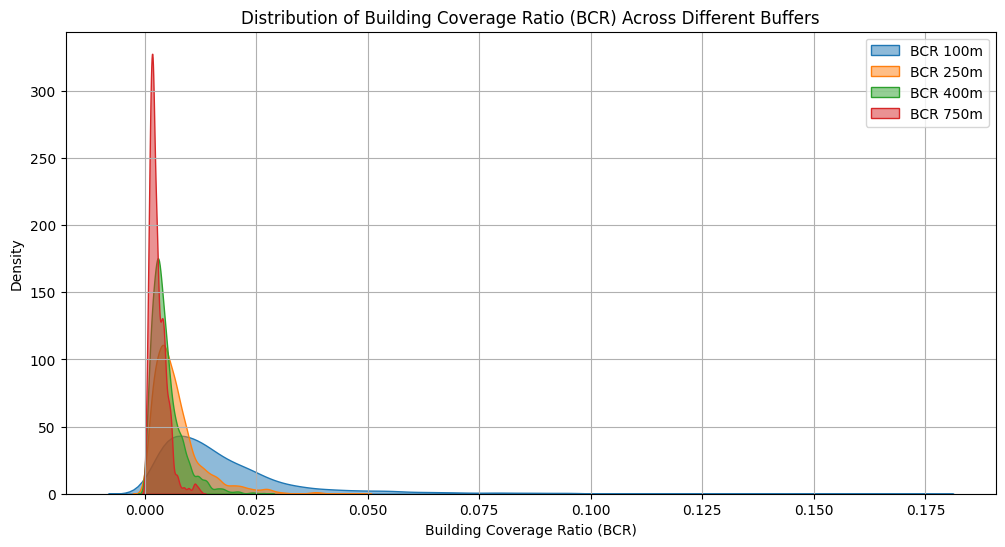

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the BCR distribution to ensure values are reasonable.
# Create a figure for visualization
plt.figure(figsize=(12, 6))

# Plot the distribution of BCR for each buffer distance
for dist in buffer_distances:
    sns.kdeplot(
        merged_buildings_gdf[f"BCR_{dist}m"],
        label=f"BCR {dist}m",
        fill=True,
        alpha=0.5
    )

# Customize plot
plt.xlabel("Building Coverage Ratio (BCR)")
plt.ylabel("Density")
plt.title("Distribution of Building Coverage Ratio (BCR) Across Different Buffers")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


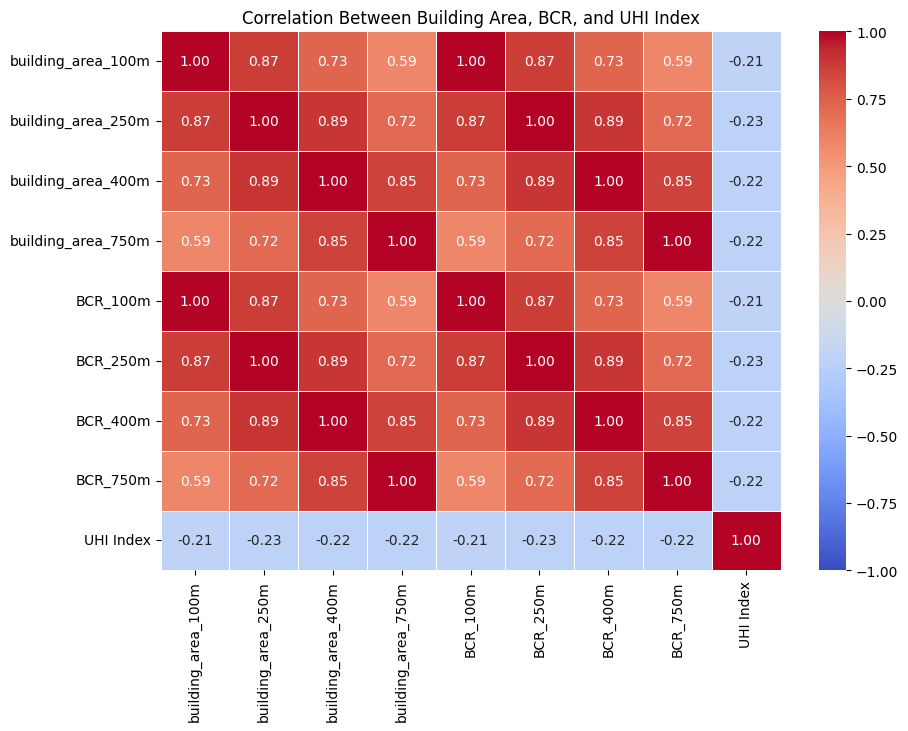

In [ ]:
# Define columns for correlation check
building_area_cols = ["building_area_100m", "building_area_250m", "building_area_400m", "building_area_750m"]
bcr_columns = ["BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m"]

# Compute correlation matrix
correlation_data = merged_buildings_gdf[building_area_cols + bcr_columns + ["UHI Index"]]

# Plot correlation heatmap
#plt.figure(figsize=(20, 20))
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# building_area columns and BCR columns are highly correlated (~1.00)
building_area_cols = ["building_area_100m", "building_area_250m", "building_area_400m", "building_area_750m"]
# Drop this columns to reduce redundancy
merged_buildings_gdf.drop(columns=building_area_cols, inplace=True)

In [ ]:
merged_buildings_gdf.head(1)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,...,mean_bldg_height_250m,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),5,10,15,...,72.870384,189.393844,63.988923,189.393844,42.275311,189.393844,0.010361,0.003711,0.00191,0.001268


In [ ]:
# Convert back to EPSG:4326 for correct latitude & longitude representation
merged_buildings_gdf = merged_buildings_gdf.to_crs(epsg=4326)

In [ ]:
# Save the merged_buildings_gdf to a CSV file
merged_buildings_gdf.to_csv("/content/drive/MyDrive/EY Challenge 2025/Dataset/merged_buildings_features_gdf.csv", index=False)

In [ ]:
# Building Density Feature
merged_buildings_gdf.sample(5)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,...,mean_bldg_height_250m,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m
1340,-73.984930,40.784490,0.969464,13.86,52.0,387.247900,POINT (988423.326 225088.096),5,17,24,...,9.783529,13.86,8.662500,13.86,61.009100,190.05,0.001324,0.000847,0.000414,0.003452
8187,-73.898523,40.810512,0.978240,24.99,11.0,541.817193,POINT (1012340.886 234584.608),7,20,29,...,26.743500,30.00,26.890345,30.00,27.912500,30.00,0.005887,0.002724,0.001551,0.000758
8860,-73.960923,40.810017,0.997713,157.00,141.0,77.799526,POINT (995067.33 234390.404),5,13,30,...,163.000000,211.00,192.633333,228.00,158.223341,228.00,0.024987,0.010792,0.011497,0.006088
5555,-73.976250,40.786618,0.976436,67.84,84.0,12.963480,POINT (990826.863 225864.051),11,26,40,...,85.165769,225.00,98.286250,228.00,97.112821,228.00,0.024681,0.011277,0.007821,0.004286
4714,-73.896818,40.834095,0.991462,54.85,82.0,82.327451,POINT (1012802.745 243177.416),6,20,32,...,51.673500,57.10,45.493546,64.14,42.691654,64.14,0.007835,0.005263,0.002896,0.001401


Compute Nearest Building Distance feature

In [ ]:
# Load the merged buildings dataset
merged_path = "/content/drive/MyDrive/EY Challenge 2025/Dataset/merged_buildings_features_gdf.csv"
merged_buildings_gdf = pd.read_csv(merged_path)

# Display basic info
print("\nBasic information")
print(merged_buildings_gdf.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(merged_buildings_gdf.isnull().sum())

# You can further explore the dataset using other pandas functions
# such as merged_buildings_gdf.head(), merged_buildings_gdf.describe(), etc.



Basic information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Longitude              11229 non-null  float64
 1   Latitude               11229 non-null  float64
 2   UHI Index              11229 non-null  float64
 3   HEIGHTROOF             11229 non-null  float64
 4   GROUNDELEV             11229 non-null  float64
 5   distance_to_building   11229 non-null  float64
 6   geometry               11229 non-null  object 
 7   building_density_100m  11229 non-null  int64  
 8   building_density_250m  11229 non-null  int64  
 9   building_density_400m  11229 non-null  int64  
 10  building_density_750m  11229 non-null  int64  
 11  mean_bldg_height_100m  11229 non-null  float64
 12  max_bldg_height_100m   11229 non-null  float64
 13  mean_bldg_height_250m  11229 non-null  float64
 14  max_bldg_height_250m   11229 non-nu

In [ ]:
merged_buildings_gdf.head(5)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,...,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m,nearest_building_distance
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),5,10,15,...,189.393844,63.988923,189.393844,42.275311,189.393844,0.010361,0.003711,0.001910,0.001268,23.140590
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263,POINT (1009388.093 235504.35),5,11,17,...,189.393844,60.001403,189.393844,42.130398,189.393844,0.010361,0.003964,0.002029,0.001287,23.140590
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477,POINT (1009380.276 235480.052),6,12,18,...,189.393844,58.313547,189.393844,42.379839,189.393844,0.012433,0.004209,0.002088,0.001271,25.524784
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327,POINT (1009372.92 235454.541),7,12,20,...,189.393844,55.444192,189.393844,42.638875,189.393844,0.018462,0.004209,0.002206,0.001255,23.444006
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070,POINT (1009368.791 235431.463),8,13,21,...,189.393844,54.172564,189.393844,43.232528,189.393844,0.020040,0.004470,0.002263,0.001272,23.444006


In [ ]:
merged_buildings_gdf.head(1)

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,...,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m,nearest_building_distance
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (1009393.606 235526.824),5,10,15,...,189.393844,63.988923,189.393844,42.275311,189.393844,0.010361,0.003711,0.00191,0.001268,23.14059


In [ ]:
# Convert back to EPSG:4326 for correct latitude & longitude representation
merged_buildings_gdf = merged_buildings_gdf.to_crs(epsg=4326)

In [ ]:
merged_buildings_gdf.columns

Index(['Longitude', 'Latitude', 'UHI Index', 'HEIGHTROOF', 'GROUNDELEV',
       'distance_to_building', 'geometry', 'building_density_100m',
       'building_density_250m', 'building_density_400m',
       'building_density_750m', 'mean_bldg_height_100m',
       'max_bldg_height_100m', 'mean_bldg_height_250m', 'max_bldg_height_250m',
       'mean_bldg_height_400m', 'max_bldg_height_400m',
       'mean_bldg_height_750m', 'max_bldg_height_750m', 'BCR_100m', 'BCR_250m',
       'BCR_400m', 'BCR_750m', 'nearest_building_distance'],
      dtype='object')

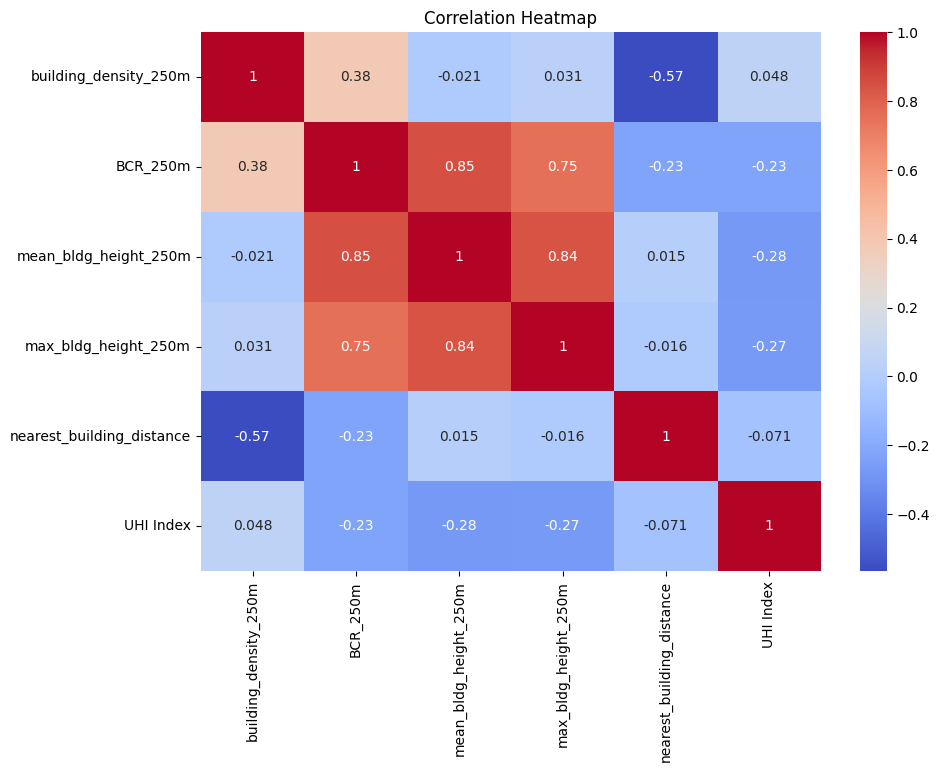

In [ ]:
# Define columns for correlation check

bcr_columns = ["building_density_250m", "BCR_250m", "mean_bldg_height_250m", "max_bldg_height_250m","nearest_building_distance"]

# Compute correlation matrix
# Remove building_area_cols from the list of columns as they have been dropped
correlation_data = merged_buildings_gdf[bcr_columns + ["UHI Index"]]

# Plot correlation heatmap
#plt.figure(figsize=(20, 20))
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

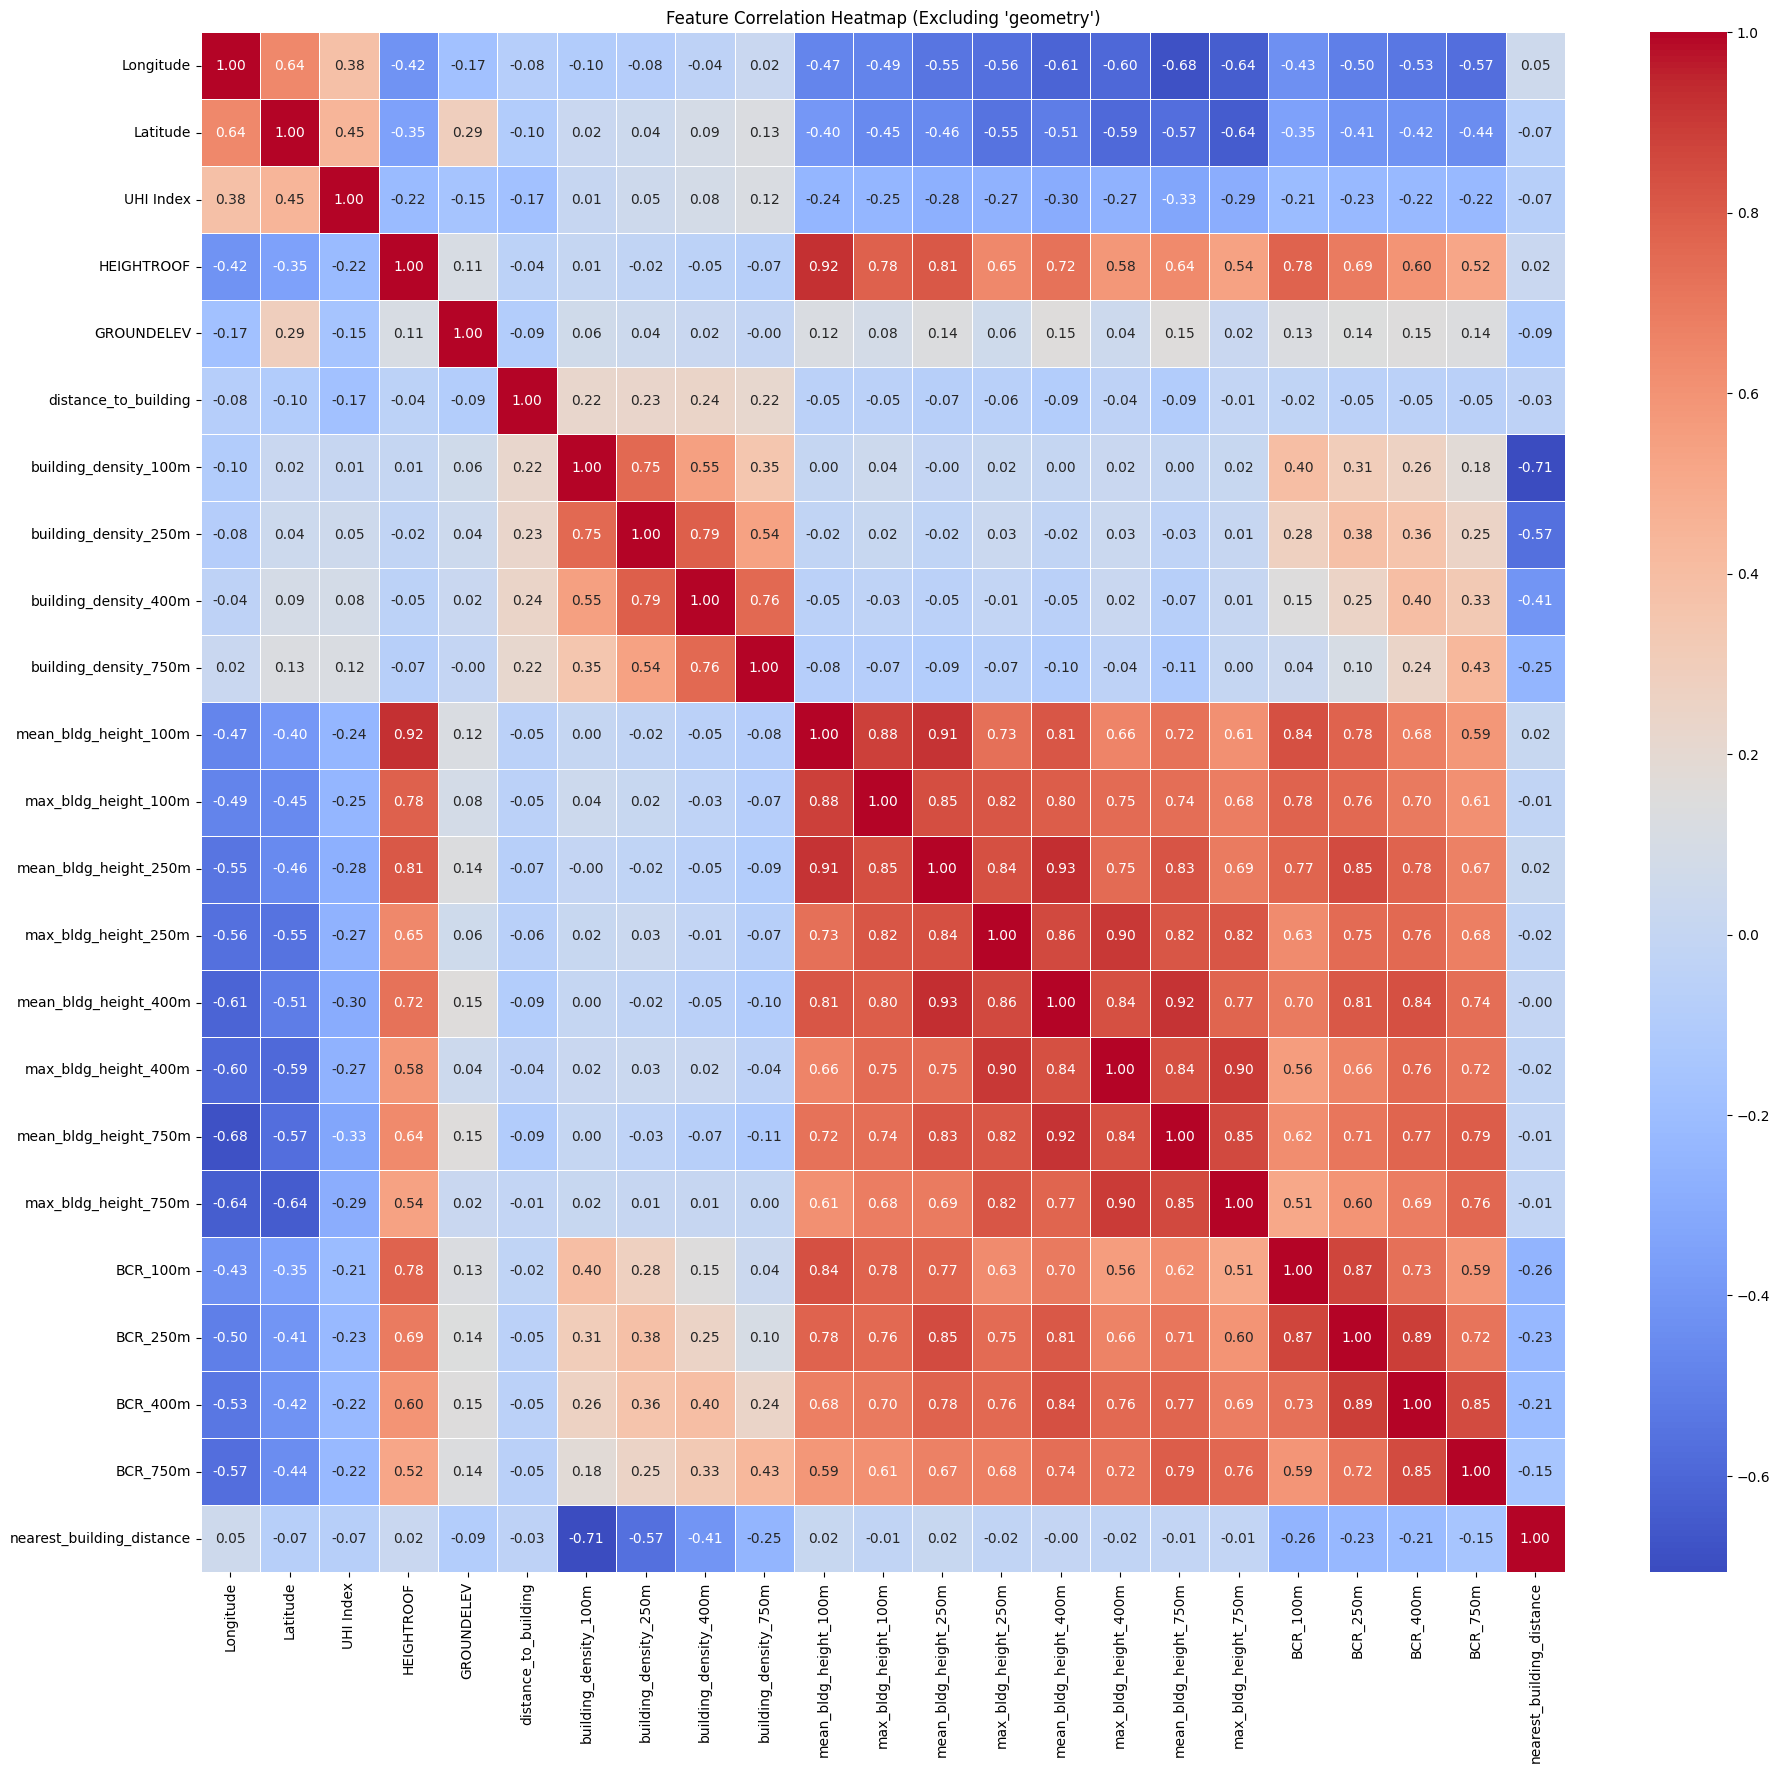

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns (automatically excludes 'geometry')
correlation_matrix = merged_buildings_gdf.select_dtypes(include=['number']).corr()

# Plot heatmap
plt.figure(figsize=(22, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Excluding 'geometry')")
plt.show()


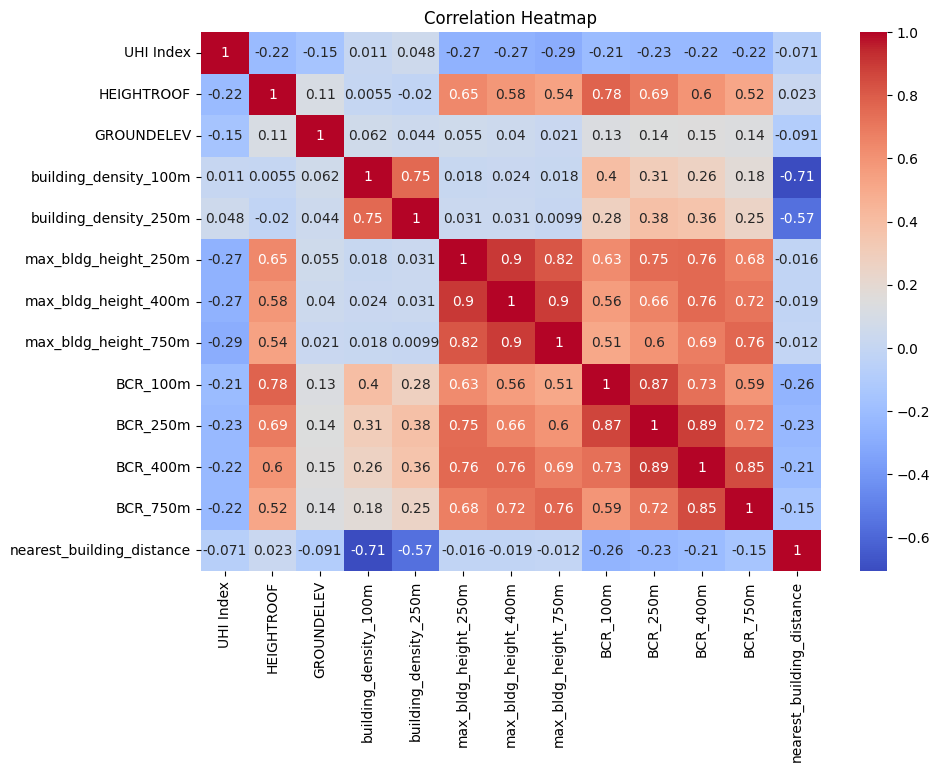

In [ ]:
# Define columns for correlation check

bcr_columns = ["HEIGHTROOF ", "GROUNDELEV ", "mean_bldg_height_250m", "max_bldg_height_250m","nearest_building_distance"]

# Define the selected features based on the correlation analysis
selected_features = [
    "UHI Index", "HEIGHTROOF", "GROUNDELEV",
    "building_density_100m", "building_density_250m",
    "max_bldg_height_250m", "max_bldg_height_400m", "max_bldg_height_750m",
    "BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m"
]
# Compute correlation matrix
# Remove building_area_cols from the list of columns as they have been dropped
correlation_data = merged_buildings_gdf[selected_features]

# Plot correlation heatmap
#plt.figure(figsize=(20, 20))
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
merged_buildings_gdf.drop(columns=["geometry"], inplace=True)

# Merge datasets

In [18]:
# Load the environmental data
environmental_data_path = "/content/drive/MyDrive/EY Challenge 2025/Dataset/environmental_final_data.csv"
environmental_df = pd.read_csv(environmental_data_path)

# Display basic info
print("\nBasic information of environmental data")
print(environmental_df.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column of environmental data")
print(environmental_df.isnull().sum())

# You can further explore the dataset using other pandas functions
# such as environmental_df.head(), environmental_df.describe(), etc.




Basic information of environmental data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Longitude                    11229 non-null  float64
 1   Latitude                     11229 non-null  float64
 2   UHI Index                    11229 non-null  float64
 3   Air Temp at Surface [degC]   11229 non-null  float64
 4   Relative Humidity [percent]  11229 non-null  float64
 5   Avg Wind Speed [m/s]         11229 non-null  float64
 6   Wind Direction [degrees]     11229 non-null  int64  
 7   Solar Flux [W/m^2]           11229 non-null  int64  
 8   Heat Index (C)               11229 non-null  float64
 9   Wind_Cooling_Effect          11229 non-null  float64
 10  B01                          11229 non-null  float64
 11  B02                          11229 non-null  float64
 12  B03                          1122

In [19]:
# Load the merged buildings dataset
merged_path = "/content/drive/MyDrive/EY Challenge 2025/Dataset/merged_buildings_features_gdf.csv"
merged_buildings_gdf = pd.read_csv(merged_path)

# Display basic info
print("\nBasic information")
print(merged_buildings_gdf.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(merged_buildings_gdf.isnull().sum())

# You can further explore the dataset using other pandas functions
# such as merged_buildings_gdf.head(), merged_buildings_gdf.describe(), etc.

merged_buildings_gdf.head(5)



Basic information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Longitude              11229 non-null  float64
 1   Latitude               11229 non-null  float64
 2   UHI Index              11229 non-null  float64
 3   HEIGHTROOF             11229 non-null  float64
 4   GROUNDELEV             11229 non-null  float64
 5   distance_to_building   11229 non-null  float64
 6   geometry               11229 non-null  object 
 7   building_density_100m  11229 non-null  int64  
 8   building_density_250m  11229 non-null  int64  
 9   building_density_400m  11229 non-null  int64  
 10  building_density_750m  11229 non-null  int64  
 11  mean_bldg_height_100m  11229 non-null  float64
 12  max_bldg_height_100m   11229 non-null  float64
 13  mean_bldg_height_250m  11229 non-null  float64
 14  max_bldg_height_250m   11229 non-nu

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,distance_to_building,geometry,building_density_100m,building_density_250m,building_density_400m,...,mean_bldg_height_250m,max_bldg_height_250m,mean_bldg_height_400m,max_bldg_height_400m,mean_bldg_height_750m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,93.018687,POINT (-73.90916667 40.81310667000001),5,10,15,...,72.870384,189.393844,63.988923,189.393844,42.275311,189.393844,0.010361,0.003711,0.001910,0.001268
1,-73.909187,40.813045,1.030289,65.1,34.0,83.531263,POINT (-73.90918667 40.813045),5,11,17,...,70.752168,189.393844,60.001403,189.393844,42.130398,189.393844,0.010361,0.003964,0.002029,0.001287
2,-73.909215,40.812978,1.023798,65.1,34.0,81.627477,POINT (-73.909215 40.812978329999986),6,12,18,...,68.876987,189.393844,58.313547,189.393844,42.379839,189.393844,0.012433,0.004209,0.002088,0.001271
3,-73.909242,40.812908,1.023798,65.1,34.0,87.101327,POINT (-73.90924167 40.81290832999999),7,12,20,...,68.876987,189.393844,55.444192,189.393844,42.638875,189.393844,0.018462,0.004209,0.002206,0.001255
4,-73.909257,40.812845,1.021634,65.1,34.0,95.764070,POINT (-73.90925667 40.81284500000002),8,13,21,...,67.511834,189.393844,54.172564,189.393844,43.232528,189.393844,0.020040,0.004470,0.002263,0.001272


In [20]:
# Keep only selected columns
bldg_columns = ['Longitude', 'Latitude', 'UHI Index', 'HEIGHTROOF', 'GROUNDELEV',
                    'building_density_100m', 'building_density_250m',
                    'max_bldg_height_250m', 'max_bldg_height_400m', 'max_bldg_height_750m',
                    'BCR_100m', 'BCR_250m', 'BCR_400m', 'BCR_750m']

merged_buildings_gdf = merged_buildings_gdf[bldg_columns]


In [21]:
merged_buildings_gdf

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,building_density_100m,building_density_250m,max_bldg_height_250m,max_bldg_height_400m,max_bldg_height_750m,BCR_100m,BCR_250m,BCR_400m,BCR_750m
0,-73.909167,40.813107,1.030289,65.1,34.0,5,10,189.393844,189.393844,189.393844,0.010361,0.003711,0.001910,0.001268
1,-73.909187,40.813045,1.030289,65.1,34.0,5,11,189.393844,189.393844,189.393844,0.010361,0.003964,0.002029,0.001287
2,-73.909215,40.812978,1.023798,65.1,34.0,6,12,189.393844,189.393844,189.393844,0.012433,0.004209,0.002088,0.001271
3,-73.909242,40.812908,1.023798,65.1,34.0,7,12,189.393844,189.393844,189.393844,0.018462,0.004209,0.002206,0.001255
4,-73.909257,40.812845,1.021634,65.1,34.0,8,13,189.393844,189.393844,189.393844,0.020040,0.004470,0.002263,0.001272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,12.0,55.0,13,25,12.000000,175.080000,175.080000,0.004966,0.001528,0.002370,0.001800
11225,-73.957063,40.790308,0.972470,12.0,55.0,12,24,12.000000,175.080000,175.080000,0.004584,0.001467,0.002694,0.001793
11226,-73.957093,40.790270,0.981124,12.0,55.0,10,23,12.000000,175.080000,175.080000,0.003820,0.001406,0.002647,0.001787
11227,-73.957112,40.790253,0.981245,12.0,55.0,9,22,12.000000,175.080000,175.080000,0.003438,0.001345,0.002647,0.001780


In [22]:
# prompt: keep only selected columns from environmental_df
#  selected_columns=['B01','B06', 'NDVI', 'NDBI', 'Air Temp at Surface [degC]', 'Heat Index (C)', 'Solar Flux [W/m^2]']

env_columns = ['Longitude', 'Latitude', 'UHI Index', 'B01','B06', 'NDVI', 'NDBI', 'Air Temp at Surface [degC]', 'Heat Index (C)', 'Solar Flux [W/m^2]']

# Keep only selected columns in environmental_df
environmental_df = environmental_df[env_columns]


In [23]:
environmental_df

,Longitude,Latitude,UHI Index,B01,B06,NDVI,NDBI,Air Temp at Surface [degC],Heat Index (C),Solar Flux [W/m^2]
0,-73.909167,40.813107,1.030289,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621
1,-73.909187,40.813045,1.030289,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621
2,-73.909215,40.812978,1.023798,846.0,1668.0,0.510866,-0.198358,27.2,27.434996,621
3,-73.909242,40.812908,1.023798,846.0,1668.0,0.537161,-0.196600,27.2,27.434996,621
4,-73.909257,40.812845,1.021634,846.0,1728.0,0.478474,-0.155361,27.2,27.434996,621
...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,481.0,2382.0,0.722980,-0.285071,26.8,27.053202,605
11225,-73.957063,40.790308,0.972470,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605
11226,-73.957093,40.790270,0.981124,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605
11227,-73.957112,40.790253,0.981245,481.0,2382.0,0.652422,-0.226994,27.0,27.187914,620


In [24]:
# Merge the environmental dataset with the building dataset on Longitude & Latitude
final_merged_df = merged_buildings_gdf.merge(environmental_df, on=['Longitude', 'Latitude', 'UHI Index'], how='left')

In [26]:
# Print sample rows to verify the merge
final_merged_df

,Longitude,Latitude,UHI Index,HEIGHTROOF,GROUNDELEV,building_density_100m,building_density_250m,max_bldg_height_250m,max_bldg_height_400m,max_bldg_height_750m,...,BCR_250m,BCR_400m,BCR_750m,B01,B06,NDVI,NDBI,Air Temp at Surface [degC],Heat Index (C),Solar Flux [W/m^2]
0,-73.909167,40.813107,1.030289,65.1,34.0,5,10,189.393844,189.393844,189.393844,...,0.003711,0.001910,0.001268,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621
1,-73.909187,40.813045,1.030289,65.1,34.0,5,11,189.393844,189.393844,189.393844,...,0.003964,0.002029,0.001287,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621
2,-73.909215,40.812978,1.023798,65.1,34.0,6,12,189.393844,189.393844,189.393844,...,0.004209,0.002088,0.001271,846.0,1668.0,0.510866,-0.198358,27.2,27.434996,621
3,-73.909242,40.812908,1.023798,65.1,34.0,7,12,189.393844,189.393844,189.393844,...,0.004209,0.002206,0.001255,846.0,1668.0,0.537161,-0.196600,27.2,27.434996,621
4,-73.909257,40.812845,1.021634,65.1,34.0,8,13,189.393844,189.393844,189.393844,...,0.004470,0.002263,0.001272,846.0,1728.0,0.478474,-0.155361,27.2,27.434996,621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,12.0,55.0,13,25,12.000000,175.080000,175.080000,...,0.001528,0.002370,0.001800,481.0,2382.0,0.722980,-0.285071,26.8,27.053202,605
11225,-73.957063,40.790308,0.972470,12.0,55.0,12,24,12.000000,175.080000,175.080000,...,0.001467,0.002694,0.001793,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605
11226,-73.957093,40.790270,0.981124,12.0,55.0,10,23,12.000000,175.080000,175.080000,...,0.001406,0.002647,0.001787,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605
11227,-73.957112,40.790253,0.981245,12.0,55.0,9,22,12.000000,175.080000,175.080000,...,0.001345,0.002647,0.001780,481.0,2382.0,0.652422,-0.226994,27.0,27.187914,620


In [27]:
final_merged_df.columns

Index(['Longitude', 'Latitude', 'UHI Index', 'HEIGHTROOF', 'GROUNDELEV',
       'building_density_100m', 'building_density_250m',
       'max_bldg_height_250m', 'max_bldg_height_400m', 'max_bldg_height_750m',
       'BCR_100m', 'BCR_250m', 'BCR_400m', 'BCR_750m', 'B01', 'B06', 'NDVI',
       'NDBI', 'Air Temp at Surface [degC]', 'Heat Index (C)',
       'Solar Flux [W/m^2]'],
      dtype='object')

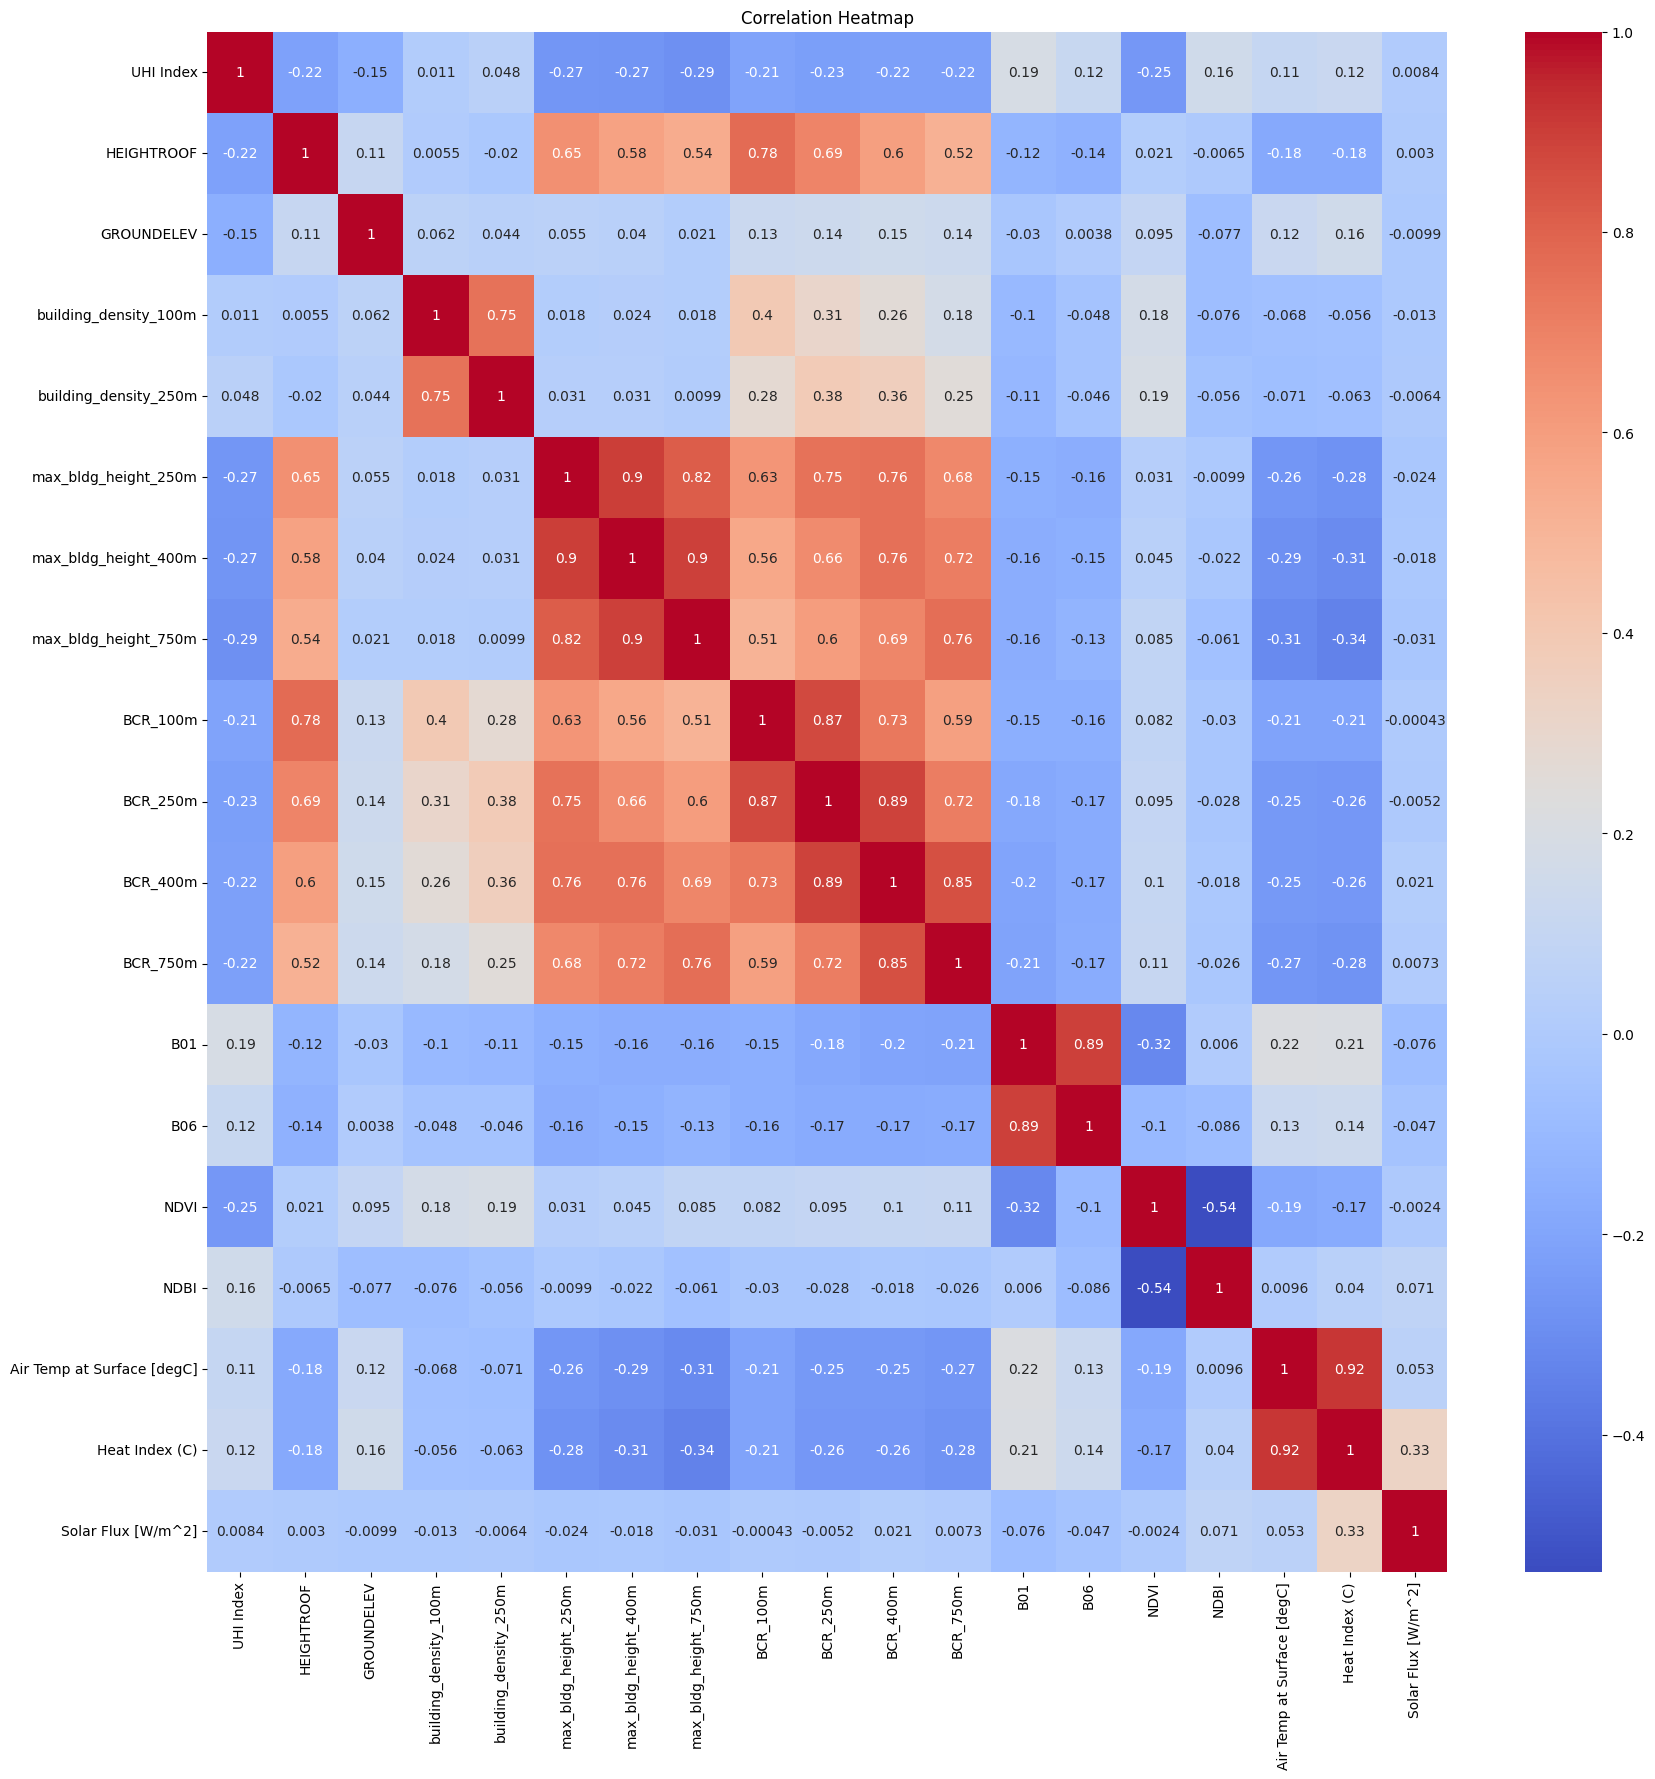

In [30]:
# Define the selected features based on the correlation analysis
selected_features = [
    'UHI Index', 'HEIGHTROOF', 'GROUNDELEV',
       'building_density_100m', 'building_density_250m',
       'max_bldg_height_250m', 'max_bldg_height_400m', 'max_bldg_height_750m',
       'BCR_100m', 'BCR_250m', 'BCR_400m', 'BCR_750m', 'B01', 'B06', 'NDVI',
       'NDBI', 'Air Temp at Surface [degC]', 'Heat Index (C)',
       'Solar Flux [W/m^2]'
]
# Compute correlation matrix
# Remove building_area_cols from the list of columns as they have been dropped
correlation_data = final_merged_df[selected_features]

# Plot correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [41]:
# Display basic statistics
print("Basic statistics")
print(final_merged_df.describe())

# Display basic info
print("\nBasic information")
print(final_merged_df.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(final_merged_df.isnull().sum())

Basic statistics
          Longitude      Latitude     UHI Index    HEIGHTROOF    GROUNDELEV  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean     -73.933927     40.808800      1.000001     69.094393     55.533796   
std        0.028253      0.023171      0.016238     70.651871     38.753114   
min      -73.994457     40.758792      0.956122      0.000000      0.000000   
25%      -73.955703     40.790905      0.988577     27.210000     26.000000   
50%      -73.932968     40.810688      1.000237     55.750000     47.000000   
75%      -73.909647     40.824515      1.011176     72.040000     80.000000   
max      -73.879458     40.859497      1.046036    715.000000    256.000000   

       building_density_100m  building_density_250m  max_bldg_height_250m  \
count           11229.000000           11229.000000          11229.000000   
mean                8.239825              20.760264            118.443585   
std                 2.897998            

# Train a Random Forest model

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Define relevant features for training
train_features = [
    "HEIGHTROOF", "GROUNDELEV", "building_density_100m", "building_density_250m",
    "max_bldg_height_250m", "max_bldg_height_400m", "max_bldg_height_750m",
    "BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m", 'B01','B06', 'NDVI', 'NDBI',
    'Air Temp at Surface [degC]', 'Heat Index (C)', 'Solar Flux [W/m^2]'
]

# Define target variable
target = "UHI Index"

# Prepare the dataset
X = final_merged_df[train_features]
y = final_merged_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [55]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [56]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9414


In [ ]:
#baseline_train_features = [
#     "HEIGHTROOF", "building_density_100m", "building_density_250m",
#     "max_bldg_height_250m", "max_bldg_height_400m", "max_bldg_height_750m",
#     "BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m"
# ]

In [ ]:
# 0.9215 -> baseline_train_features
# 0.9376 -> + GROUNDELEV


# Final Submission

In [62]:
#Reading the coordinates for the submission
submission_df = pd.read_csv('/content/drive/MyDrive/EY Challenge 2025/Dataset/Submission_template.csv')
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [63]:
# Merge the submission template with the final dataset using Latitude & Longitude
merged_submission = final_merged_df.merge(
    submission_df, on=["Longitude", "Latitude"], how="left"
)

In [64]:
merged_submission

,Longitude,Latitude,UHI Index_x,HEIGHTROOF,GROUNDELEV,building_density_100m,building_density_250m,max_bldg_height_250m,max_bldg_height_400m,max_bldg_height_750m,...,BCR_400m,BCR_750m,B01,B06,NDVI,NDBI,Air Temp at Surface [degC],Heat Index (C),Solar Flux [W/m^2],UHI Index_y
0,-73.909167,40.813107,1.030289,65.1,34.0,5,10,189.393844,189.393844,189.393844,...,0.001910,0.001268,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621,NaN
1,-73.909187,40.813045,1.030289,65.1,34.0,5,11,189.393844,189.393844,189.393844,...,0.002029,0.001287,846.0,1502.0,0.295717,-0.123490,27.2,27.434996,621,NaN
2,-73.909215,40.812978,1.023798,65.1,34.0,6,12,189.393844,189.393844,189.393844,...,0.002088,0.001271,846.0,1668.0,0.510866,-0.198358,27.2,27.434996,621,NaN
3,-73.909242,40.812908,1.023798,65.1,34.0,7,12,189.393844,189.393844,189.393844,...,0.002206,0.001255,846.0,1668.0,0.537161,-0.196600,27.2,27.434996,621,NaN
4,-73.909257,40.812845,1.021634,65.1,34.0,8,13,189.393844,189.393844,189.393844,...,0.002263,0.001272,846.0,1728.0,0.478474,-0.155361,27.2,27.434996,621,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,12.0,55.0,13,25,12.000000,175.080000,175.080000,...,0.002370,0.001800,481.0,2382.0,0.722980,-0.285071,26.8,27.053202,605,NaN
11225,-73.957063,40.790308,0.972470,12.0,55.0,12,24,12.000000,175.080000,175.080000,...,0.002694,0.001793,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605,NaN
11226,-73.957093,40.790270,0.981124,12.0,55.0,10,23,12.000000,175.080000,175.080000,...,0.002647,0.001787,481.0,2382.0,0.652422,-0.226994,26.8,27.053202,605,NaN
11227,-73.957112,40.790253,0.981245,12.0,55.0,9,22,12.000000,175.080000,175.080000,...,0.002647,0.001780,481.0,2382.0,0.652422,-0.226994,27.0,27.187914,620,NaN


In [65]:
import pandas as pd

# Extract features used for training
selected_features = [
    "HEIGHTROOF", "GROUNDELEV", "building_density_100m", "building_density_250m",
    "max_bldg_height_250m", "max_bldg_height_400m", "max_bldg_height_750m",
    "BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m", 'B01','B06', 'NDVI', 'NDBI',
    'Air Temp at Surface [degC]', 'Heat Index (C)', 'Solar Flux [W/m^2]'
]


#submission_data = merged_submission[selected_features]

# Predict UHI Index using the model
submission_df["UHI Index"] = rf_model.predict(merged_submission[selected_features])

# Save the final submission file
submission_df.to_csv("final_submission2.csv", index=False)

print("Submission file 'final_submission2.csv' created successfully!")


ValueError: Length of values (11229) does not match length of index (1040)

In [ ]:
import pandas as pd

# Extract features used for training
selected_features = [
    "HEIGHTROOF", "GROUNDELEV", "building_density_100m", "building_density_250m",
    "max_bldg_height_250m", "max_bldg_height_400m", "max_bldg_height_750m",
    "BCR_100m", "BCR_250m", "BCR_400m", "BCR_750m", 'B01', 'B06', 'NDVI', 'NDBI',
    'Air Temp at Surface [degC]', 'Heat Index (C)', 'Solar Flux [W/m^2]'
]

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
submission_data = merged_submission[selected_features].copy()

# Predict UHI Index using the model
submission_data["UHI Index"] = rf_model.predict(submission_data)

# Ensure the submission file contains the required format (Longitude, Latitude, and predicted UHI Index)
final_submission = merged_submission[["Longitude", "Latitude"]].copy()
final_submission["UHI Index"] = submission_data["UHI Index"]

# Save the final submission file
final_submission.to_csv("final_submission2.csv", index=False)

print("Submission file 'final_submission2.csv' created successfully!")
